The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.15.1


# Language Models and the Dataset
:label:`sec_language_model`


In :numref:`sec_text_preprocessing`, we see how to map text data into tokens, where these tokens can be viewed as a sequence of discrete observations, such as words or characters.
Assume that the tokens in a text sequence of length $T$ are in turn $x_1, x_2, \ldots, x_T$. 
Then, in the text sequence,
$x_t$($1 \leq t \leq T$) can be considered as the observation or label at time step $t$. Given such a text sequence,
the goal of a *language model* is to estimate the joint probability of the sequence

$$P(x_1, x_2, \ldots, x_T).$$

Language models are incredibly useful. For instance, an ideal language model would be able to generate natural text just on its own, simply by drawing one token at a time $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$.
Quite unlike the monkey using a typewriter, all text emerging from such a model would pass as natural language, e.g., English text. Furthermore, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments.
Clearly we are still very far from designing such a system, since it would need to *understand* the text rather than just generate grammatically sensible content.

Nonetheless, language models are of great service even in their limited form.
For instance, the phrases "to recognize speech" and "to wreck a nice beach" sound very similar.
This can cause ambiguity in speech recognition,
which is easily resolved through a language model that rejects the second translation as outlandish.
Likewise, in a document summarization algorithm
it is worthwhile knowing that "dog bites man" is much more frequent than "man bites dog", or that "I want to eat grandma" is a rather disturbing statement, whereas "I want to eat, grandma" is much more benign.


## Learning a Language Model

The obvious question is how we should model a document, or even a sequence of tokens. 
Suppose that we tokenize text data at the word level.
We can take recourse to the analysis we applied to sequence models in :numref:`sec_sequence`.
Let us start by applying basic probability rules:

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

For example, 
the probability of a text sequence containing four words would be given as:

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

In order to compute the language model, we need to calculate the
probability of words and the conditional probability of a word given
the previous few words.
Such probabilities are essentially
language model parameters.

Here, we
assume that the training dataset is a large text corpus, such as all
Wikipedia entries, [Project Gutenberg](https://en.wikipedia.org/wiki/Project_Gutenberg),
and all text posted on the
Web.
The probability of words can be calculated from the relative word
frequency of a given word in the training dataset.
For example, the estimate $\hat{P}(\text{deep})$ can be calculated as the
probability of any sentence starting with the word "deep". A
slightly less accurate approach would be to count all occurrences of
the word "deep" and divide it by the total number of words in
the corpus.
This works fairly well, particularly for frequent
words. Moving on, we could attempt to estimate

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

where $n(x)$ and $n(x, x')$ are the number of occurrences of singletons
and consecutive word pairs, respectively.
Unfortunately, estimating the
probability of a word pair is somewhat more difficult, since the
occurrences of "deep learning" are a lot less frequent. In
particular, for some unusual word combinations it may be tricky to
find enough occurrences to get accurate estimates.
Things take a turn for the worse for three-word combinations and beyond.
There will be many plausible three-word combinations that we likely will not see in our dataset.
Unless we provide some solution to assign such word combinations nonzero count, we will not be able to use them in a language model. If the dataset is small or if the words are very rare, we might not find even a single one of them.

A common strategy is to perform some form of *Laplace smoothing*.
The solution is to
add a small constant to all counts. 
Denote by $n$ the total number of words in
the training set
and $m$ the number of unique words.
This solution helps with singletons, e.g., via

$$\begin{aligned}
	\hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
	\hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}$$

Here $\epsilon_1,\epsilon_2$, and $\epsilon_3$ are hyperparameters.
Take $\epsilon_1$ as an example:
when $\epsilon_1 = 0$, no smoothing is applied;
when $\epsilon_1$ approaches positive infinity,
$\hat{P}(x)$ approaches the uniform probability $1/m$. 
The above is a rather primitive variant of what
other techniques can accomplish :cite:`Wood.Gasthaus.Archambeau.ea.2011`.


Unfortunately, models like this get unwieldy rather quickly
for the following reasons. First, we need to store all counts.
Second, this entirely ignores the meaning of the words. For
instance, "cat" and "feline" should occur in related contexts.
It is quite difficult to adjust such models to additional contexts,
whereas, deep learning based language models are well suited to
take this into account.
Last, long word
sequences are almost certain to be novel, hence a model that simply
counts the frequency of previously seen word sequences is bound to perform poorly there.

## Markov Models and $n$-grams

Before we discuss solutions involving deep learning, we need some more terminology and concepts. Recall our discussion of Markov Models in :numref:`sec_sequence`.
Let us apply this to language modeling. A distribution over sequences satisfies the Markov property of first order if $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

The probability formulae that involve one, two, and three variables are typically referred to as *unigram*, *bigram*, and *trigram* models, respectively. In the following, we will learn how to design better models.

## Natural Language Statistics

Let us see how this works on real data.
We construct a vocabulary based on the time machine dataset as introduced in :numref:`sec_text_preprocessing` 
and print the top 10 most frequent words.


In [1]:
from d2l import torch as d2l
import torch
import random

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessisarily a sentence or a paragraph, we
# concatenate all text lines 
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

As we can see, the most popular words are actually quite boring to look at.
They are often referred to as *stop words* and thus filtered out.
Nonetheless, they still carry meaning and we will still use them.
Besides, it is quite clear that the word frequency decays rather rapidly. The $10^{\mathrm{th}}$ most frequent word is less than $1/5$ as common as the most popular one. To get a better idea, we plot the figure of the word frequency.


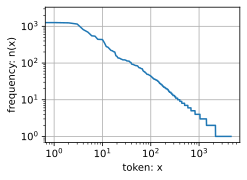

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a well-defined way.
After dealing with the first few words as exceptions, all the remaining words roughly follow a straight line on a log-log plot. This means that words satisfy *Zipf's law*,
which states that the frequency $n_i$ of the $i^\mathrm{th}$ most frequent word
is:

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

which is equivalent to

$$\log n_i = -\alpha \log i + c,$$

where $\alpha$ is the exponent that characterizes the distribution and $c$ is a constant.
This should already give us pause if we want to model words by count statistics and smoothing.
After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations, such as bigrams, trigrams, and beyond?
Let us see whether the bigram frequency behaves in the same manner as the unigram frequency.


In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book---"the time". Furthermore, let us see whether the trigram frequency behaves in the same manner.


In [5]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('here', 'and', 'there'), 15),
 (('it', 'was', 'a'), 15),
 (('i', 'did', 'not'), 14),
 (('seemed', 'to', 'me'), 14),
 (('i', 'began', 'to'), 13),
 (('i', 'saw', 'the'), 13)]

Last, let us visualize the token frequency among these three models: unigrams, bigrams, and trigrams.


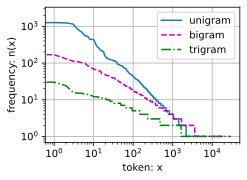

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

This figure is quite exciting for a number of reasons. First, beyond unigram words, sequences of words also appear to be following Zipf's law, albeit with a smaller exponent $\alpha$ in :eqref:`eq_zipf_law`, depending on the sequence length.
Second, the number of distinct $n$-grams is not that large. This gives us hope that there is quite a lot of structure in language.
Third, many $n$-grams occur very rarely, which makes Laplace smoothing rather unsuitable for language modeling. Instead, we will use deep learning based models.


## Reading Long Sequence Data

Since sequence data are by their very nature sequential, we need to address
the issue of processing it.
We did so in a rather ad-hoc manner in :numref:`sec_sequence`.
When sequences get too long to be processed by models
all at once,
we may wish to split such sequences for reading.
Now let us describe general strategies.
Before introducing the model,
let us assume that we will use a neural network to train a language model,
where the network processes a minibatch of sequences with predefined length, say $n$ time steps, at a time.
Now the question is how to read minibatches of features and labels at random.

To begin with,
since a text sequence can be arbitrarily long,
such as the entire *The Time Machine* book,
we can partition such a long sequence into subsequences
with the same number of time steps.
When training our neural network,
a minibatch of such subsequences
will be fed into the model.
Suppose that the network processes a subsequence
of $n$ time steps
at a time.
:numref:`fig_timemachine_5gram`
shows all the different ways to obtain subsequences
from an original text sequence, where $n=5$ and a token at each time step corresponds to a character.
Note that we have quite some freedom since we could pick an arbitrary offset that indicates the initial position.

![Different offsets lead to different subsequences when splitting up text.](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

Hence, which one should we pick from :numref:`fig_timemachine_5gram`?
In fact, all of them are equally good.
However, if we pick just one offset,
there is limited coverage of all the possible subsequences
for training our network.
Therefore,
we can start with a random offset to partition a sequence
to get both *coverage* and *randomness*.
In the following,
we describe how to accomplish this for both
*random sampling* and *sequential partitioning* strategies.


### Random Sampling

In random sampling, each example is a subsequence arbitrarily captured on the original long sequence.
The subsequences from two adjacent random minibatches
during iteration
are not necessarily adjacent on the original sequence.
For language modeling,
the target is to predict the next token based on what tokens we have seen so far, hence the labels are the original sequence, shifted by one token.

The following code randomly generates a minibatch from the data each time.
Here, the argument `batch_size` specifies the number of subsequence examples in each minibatch
and `num_steps` is the predefined number of time steps
in each subsequence.


In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset to partition a sequence
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_subseqs_per_example = num_subseqs // batch_size
    for i in range(0, batch_size * num_subseqs_per_example, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

Let us manually generate a sequence from 0 to 34.
We assume that
the batch size and numbers of time steps are 2 and 5,
respectively.
This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.


In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[19, 20, 21, 22, 23],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [15, 16, 17, 18, 19]])
X:  tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [ 5,  6,  7,  8,  9]])


### Sequential Partitioning

In addition to random sampling of the original sequence, we can also ensure that 
the subsequences from two adjacent minibatches
during iteration
are adjacent on the original sequence.
This strategy preserves the order of split subsequences when iterating over minibatches, hence is called sequential partitioning.


In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

Using the same settings,
let us print features `X` and labels `Y` for each minibatch of subsequences read by sequential partitioning.
Note that
the subsequences from two adjacent minibatches
during iteration
are indeed adjacent on the original sequence.


In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


Now we wrap the above two sampling functions to a class so that we can use it as a data iterator later.


In [11]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

Last, we define a function `load_data_time_machine` that returns both the data iterator and the vocabulary, so we can use it similarly as other other functions with the `load_data` prefix, such as `d2l.load_data_fashion_mnist` defined in :numref:`sec_fashion_mnist`.


In [12]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Summary

* Language models are key to natural language processing.
* $n$-grams provide a convenient model for dealing with long sequences by truncating the dependence.
* Long sequences suffer from the problem that they occur very rarely or never.
* Zipf's law governs the word distribution for not only unigrams but also the other $n$-grams.
* There is a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via Laplace smoothing.
* The main choices for reading long sequences are random sampling and sequential partitioning. The latter can ensure that the subsequences from two adjacent minibatches during iteration are adjacent on the original sequence.


## Exercises

1. Suppose there are $100,000$ words in the training dataset. How much word frequency and multi-word adjacent frequency does a four-gram need to store?
1. How would you model a dialogue?
1. Estimate the exponent of Zipf's law for unigrams, bigrams, and trigrams.
1. What other methods can you think of for reading long sequence data?
1. Consider the random offset that we use for reading long sequences.
    1. Why is it a good idea to have a random offset?
    1. Does it really lead to a perfectly uniform distribution over the sequences on the document?
    1. What would you have to do to make things even more uniform?
1. If we want a sequence example to be a complete sentence, what kind of problem does this introduce in minibatch sampling? How can we fix the problem?


[Discussions](https://discuss.d2l.ai/t/118)
